In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import corner
import numpy as np
import matplotlib.pyplot as plt

import sys 
sys.path.append('..')
from functions import *
# from colormaps import new_colors
cmap = plt.get_cmap('tab10')
new_colors = cmap(range(10))

3.0rc2


In [4]:
run='Vmax_4'

config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)

5SHMR+scatter (Vmax@Mpeak)


In [3]:
best_params = [ 0.53903687,  0.11330591,  2.72161542, 11.01133551,  0.11815845,  0.70730249,  0.28967114]

2x10^8 Msun
- send me a catalog of these objects with : M*, Mhalo, Mpeak, vMax@mpeak

In [5]:
stellar_masses = get_chris_stellar_masses(best_params, config, sim_data)

In [24]:
halo_data = sim_data['halocat'].halo_table

In [25]:
# halo_data = halo_data['halo_mvir','halo_mpeak','halo_Vmax@Mpeak']
halo_data['M_*'] = stellar_masses

In [26]:
dwarf_mass = np.log10(2e8)
dwarf_halos = halo_data[(halo_data['M_*']>dwarf_mass-0.01) & (halo_data['M_*']<dwarf_mass+0.01)]

In [27]:
dwarf_halos

halo_upid,halo_y,halo_x,halo_z,halo_Vmax@Mpeak,halo_rvir,halo_vy,halo_id,halo_vx,halo_mpeak,halo_vz,halo_mvir,halo_hostid,halo_mvir_host_halo,M_*
int64,float32,float32,float32,float64,float32,float32,int64,float32,float32,float32,float32,int64,float32,float64
2402706118,36.25934,13.52523,35.00034,62.26,0.032241,75.52,2402706263,-236.68,8678000000.0,-239.47,3099000000.0,2402706118,77050000000000.0,8.294855460500223
2402706118,37.4116,13.4498,35.19417,84.75,0.056388002,-321.09,2402706295,-383.74,43700000000.0,-427.27,16580000000.0,2402706118,77050000000000.0,8.298513528762323
2402692728,34.25197,7.90566,33.83302,84.04,0.036492,-123.25,2402692722,261.81,41070000000.0,-466.18,4494000000.0,2402692728,754400000000.0,8.29193202552078
2402681412,44.99104,20.4583,11.42659,70.32,0.035632998,130.99,2402681492,-83.71,15810000000.0,443.29,4184000000.0,2402681412,33660000000000.0,8.303168309649607
2402482522,10.35958,9.66273,20.82119,70.97,0.035187,195.35,2402482541,-361.45,20770000000.0,-486.53,4029000000.0,2402482522,10430000000000.0,8.303324484638754
2404159412,25.09214,46.80882,14.44215,82.35,0.029930001,-159.48,2404159442,-258.4,53000000000.0,-306.14,2480000000.0,2404159412,8352000000000.0,8.299980956611824
2404171088,24.56999,34.10798,37.88708,97.62,0.034261003,-83.53,2404171108,-246.28,64780000000.0,-111.19,3719000000.0,2404171088,7403000000000.0,8.291266923652445
2402696899,37.63858,2.43797,21.67661,77.48,0.045977,-27.61,2402696906,-213.75,39360000000.0,-3.56,8988000000.0,2402696899,2113000000000.0,8.30424195189296
2402496043,13.98936,6.56939,47.24768,54.81,0.035632998,90.5,2402496055,-421.98,18290000000.0,-255.59,4184000000.0,2402496043,2916000000000.0,8.30779908668289


In [39]:
dwarf_halos.keys()

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_Vmax@Mpeak',
 'halo_rvir',
 'halo_vy',
 'halo_id',
 'halo_vx',
 'halo_mpeak',
 'halo_vz',
 'halo_mvir',
 'halo_hostid',
 'halo_mvir_host_halo',
 'M_*']

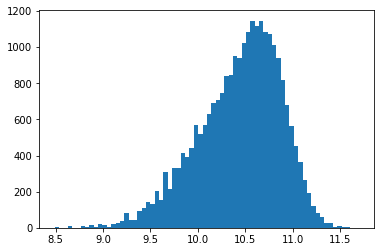

In [23]:
plt.hist(np.log10(dwarf_halos['halo_mvir']), bins=70)
plt.xlim
plt.show()

In [30]:
from astropy.io.ascii import write

In [35]:
dwarf_halos.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_catalog.hdf5',
                  path ='catalog', overwrite=True )



In [36]:
dwarf_halos_reduced = dwarf_halos['halo_mvir','halo_mpeak','halo_Vmax@Mpeak','M_*']
dwarf_halos_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_catalog_short.hdf5',
                  path ='catalog', overwrite=True )